IMPORT ALL NECESSARY LIBRARIES: 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, concatenate
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import pickle
from sklearn import svm
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

ISOLATION FOREST:

Load and prepare data:

In [2]:
df = pd.read_csv('D:\dataset_small_non-labelled.csv')
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1].apply(lambda x: 0 if x == 'normal' else 1)

Split dataset into training and testing:

In [3]:
train_ratio = 0.70
train_size = int(len(df_X) * train_ratio)
X_train = df_X.iloc[:train_size, :]
y_train = df_y.iloc[:train_size]
X_test = df_X.iloc[train_size:, :]
y_test = df_y.iloc[train_size:]

Train the model:

In [4]:
clf = IsolationForest(random_state=42)
clf.fit(X_train)

IsolationForest(random_state=42)

Test the performance of the model:

In [5]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
for label in report:
    if label not in ["accuracy", "macro avg", "weighted avg"]:
        if np.isscalar(report[label]['precision']):
            report[label]['precision'] = [report[label]['precision']]
        if np.isscalar(report[label]['recall']):
            report[label]['recall'] = [report[label]['recall']]
print("Classification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Classification report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.82      0.90       866

    accuracy                           0.82       866
   macro avg       0.50      0.41      0.45       866
weighted avg       1.00      0.82      0.90       866



Heatmap:

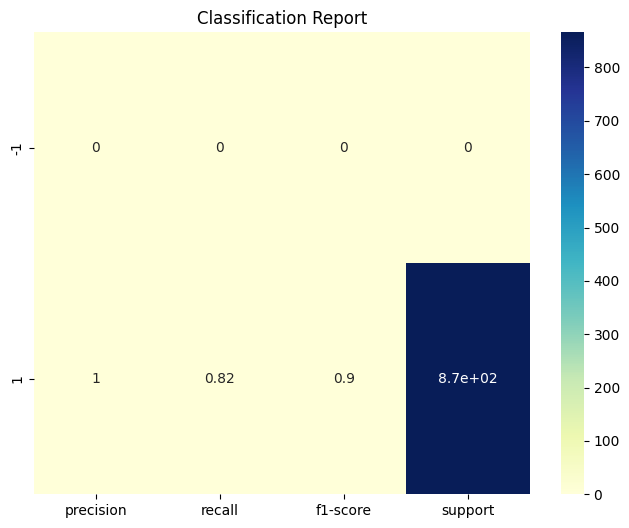

In [6]:
for label in report:
    if label not in ["accuracy", "macro avg", "weighted avg"]:
        report[label]['precision'] = float(report[label]['precision'][0])
        report[label]['recall'] = float(report[label]['recall'][0])

report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-3, :].astype(float), annot=True, cmap='YlGnBu')
plt.title("Classification Report")
plt.show()

LOCAL OUTLIER FACTOR:

Load and prepare dataset:

In [7]:
df = pd.read_csv('D:\dataset_small_non-labelled.csv')
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1].apply(lambda x: 0 if x == 'normal' else 1)

Split dataset into training and testing:

In [8]:
train_ratio = 0.70
train_size = int(len(df_X) * train_ratio)
X_train = df_X.iloc[:train_size, :]
y_train = df_y.iloc[:train_size]
X_test = df_X.iloc[train_size:, :]
y_test = df_y.iloc[train_size:]

Train the model:

In [9]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.01)

Test the performance of the model:

In [10]:
lof_pred_train = lof.fit_predict(X_train)
lof_pred_test = lof.fit_predict(X_test)
print("Training set accuracy:", accuracy_score(y_train, lof_pred_train))
print("Test set accuracy:", accuracy_score(y_test, lof_pred_test))

Training set accuracy: 0.9895988112927192
Test set accuracy: 0.9896073903002309


Confusion matrix heatmap:

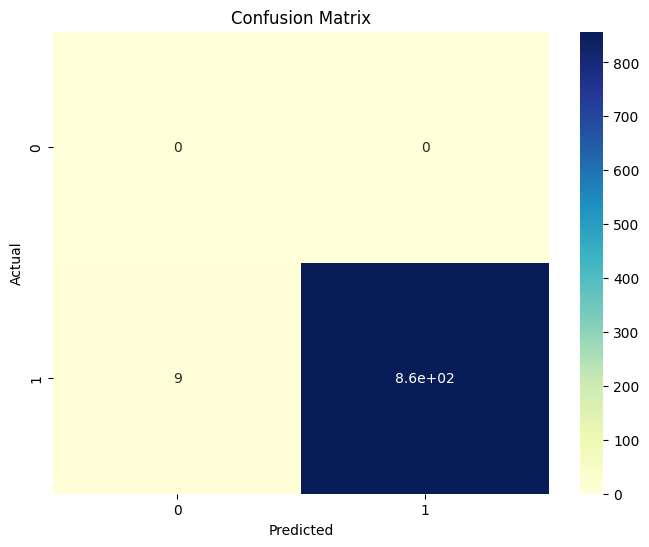

In [11]:
cm = confusion_matrix(y_test, lof_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

COMBINATION OF LOCAL OUTLIER FACTOR AND SUPPORT VECTOR MACHINE:

Load and prepare dataset:

In [12]:
df = pd.read_csv("D:\dataset_small_non-labelled.csv")
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1].apply(lambda x: 0 if x == 'normal' else 1)

Split dataset into training and testing:

In [13]:
train_ratio = 0.70
train_size = int(len(df_X) * train_ratio)
X_train = df_X.iloc[:train_size, :]
y_train = df_y.iloc[:train_size]
X_test = df_X.iloc[train_size:, :]
y_test = df_y.iloc[train_size:]

Train and predict the LOF model:

In [14]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof.fit(X_train)
lof_pred_train = lof.fit_predict(X_train)
lof_pred_test = lof.fit_predict(X_test)

Train and predict the SVM model:

In [15]:
svm = OneClassSVM(kernel='rbf', nu=0.01)
svm.fit(X_train)
svm_pred_train = svm.predict(X_train)
svm_pred_test = svm.predict(X_test)

Combine LOF and SVM predictions and evaluate:

In [16]:
final_pred_train = np.zeros(len(X_train))
final_pred_test = np.zeros(len(X_test))
for i in range(len(X_train)):
    if lof_pred_train[i] == 1 and svm_pred_train[i] == 1:
        final_pred_train[i] = 1
for i in range(len(X_test)):
    if lof_pred_test[i] == 1 and svm_pred_test[i] == 1:
        final_pred_test[i] = 1
print("Training set accuracy:", accuracy_score(y_train, final_pred_train))
print("Test set accuracy:", accuracy_score(y_test, final_pred_test))

Training set accuracy: 0.9801882119861317
Test set accuracy: 0.8568129330254042


Confusion matrix heatmap:

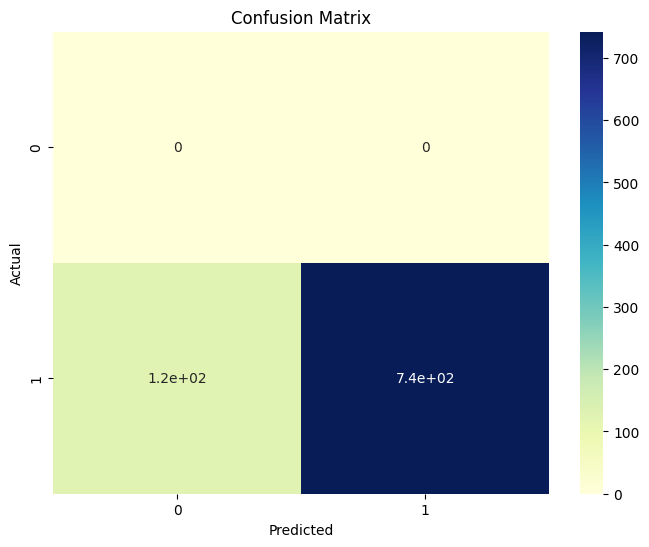

In [17]:
cm = confusion_matrix(y_test, final_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

GAUSSIAN MIXTURE MODEL:

Load and preprocess dataset:

In [18]:
df = pd.read_csv('D:\dataset_small_non-labelled.csv')
scaler = StandardScaler()
X = scaler.fit_transform(df)

Train the GMM Model:

In [19]:
gmm = GaussianMixture(n_components=10, covariance_type='full')
gmm.fit(X)

GaussianMixture(n_components=10)

Evaluate the model:

In [20]:
scores = -gmm.score_samples(X)
threshold = 2.5 * scores.mean()
anomaly_indices = np.where(scores > threshold)[0]
print('Number of anomalies:', len(anomaly_indices))

Number of anomalies: 2885


Heatmap:

Number of anomalies: 2885


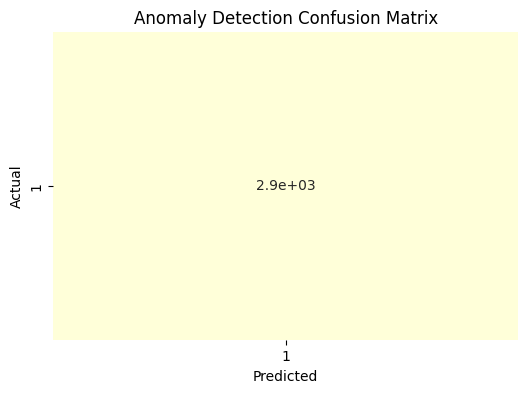

In [21]:
df['IsAnomaly'] = 0
df.loc[anomaly_indices, 'IsAnomaly'] = 1
print('Number of anomalies:', len(anomaly_indices))
confusion_matrix = pd.crosstab(df['IsAnomaly'], df['IsAnomaly'])
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', cbar=False)
plt.title("Anomaly Detection Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

PRINCIPAL COMPONENT ANALYSIS:

Load and preprocess dataset:

In [22]:
df = pd.read_csv('D:\dataset_small_non-labelled.csv')
scaler = StandardScaler()
pca = PCA(n_components=10)

Train the pipeline and extract principal components:

In [23]:
pipeline = Pipeline([('scaler', scaler), ('pca', pca)])
pipeline.fit(df)
pc = pipeline.transform(df)

Train Isolation Forest:

In [24]:
model = IsolationForest(contamination=0.01)
model.fit(pc)

IsolationForest(contamination=0.01)

Detect Anomalies:

In [25]:
anomaly_indices = np.where(model.predict(pc) == -1)[0]
print('Number of anomalies:', len(anomaly_indices))

Number of anomalies: 28


Heatmap:

Number of anomalies: 28


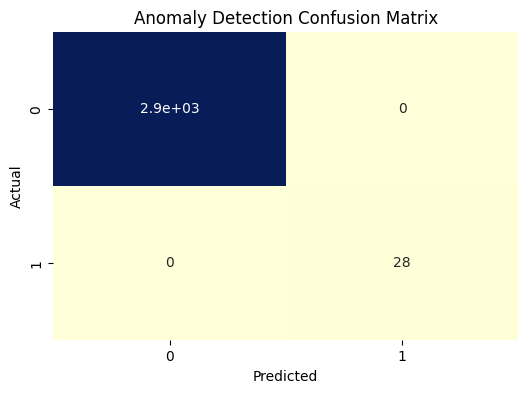

In [26]:
df['IsAnomaly'] = 0
df.loc[anomaly_indices, 'IsAnomaly'] = 1
print('Number of anomalies:', len(anomaly_indices))
confusion_matrix = pd.crosstab(df['IsAnomaly'], df['IsAnomaly'])
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', cbar=False)
plt.title("Anomaly Detection Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

AUTOENCODERS:

Load and normalize dataset:

In [27]:
data = pd.read_csv("D:\dataset_small_non-labelled.csv")
train_data = data.values
train_data = (train_data - np.min(train_data)) / (np.max(train_data) - np.min(train_data))

Define autoencoder model:

In [28]:
input_layer = layers.Input(shape=(train_data.shape[1],))
encoded = layers.Dense(32, activation='relu')(input_layer)
decoded = layers.Dense(train_data.shape[1], activation='sigmoid')(encoded)
autoencoder = tf.keras.Model(input_layer, decoded)

Compile and Train model:

In [29]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(train_data, train_data, epochs=50, batch_size=10, shuffle=True)

Epoch 1/50
289/289 [==============================] - 4s 5ms/step - loss: 0.1074
Epoch 2/50
289/289 [==============================] - 1s 4ms/step - loss: 0.0031
Epoch 3/50
289/289 [==============================] - 1s 4ms/step - loss: 7.2148e-04
Epoch 4/50
289/289 [==============================] - 1s 4ms/step - loss: 3.4069e-04
Epoch 5/50
289/289 [==============================] - 1s 4ms/step - loss: 2.0963e-04
Epoch 6/50
289/289 [==============================] - 1s 5ms/step - loss: 1.4931e-04
Epoch 7/50
289/289 [==============================] - 1s 5ms/step - loss: 1.1677e-04
Epoch 8/50
289/289 [==============================] - 2s 5ms/step - loss: 9.7342e-05
Epoch 9/50
289/289 [==============================] - 1s 4ms/step - loss: 8.4907e-05
Epoch 10/50
289/289 [==============================] - 1s 4ms/step - loss: 7.6519e-05
Epoch 11/50
289/289 [==============================] - 2s 5ms/step - loss: 7.0638e-05
Epoch 12/50
289/289 [==============================] - 2s 5ms/step - lo

Evaluate Performance:

In [30]:
predictions = autoencoder.predict(train_data)
mse = np.mean(np.power(train_data - predictions, 2), axis=1)
threshold = np.mean(mse) + 1.5*np.std(mse)
anomalies = np.where(mse > threshold)[0]
y_true = np.zeros(train_data.shape[0])
y_true[anomalies] = 1
y_pred = mse > threshold
f1 = f1_score(y_true, y_pred, average='binary')
print("F1 score:", f1)
print("Number of anomalies:", len(anomalies))

91/91 [==============================] - 1s 4ms/step
F1 score: 1.0
Number of anomalies: 165


Plot ROC Curve:

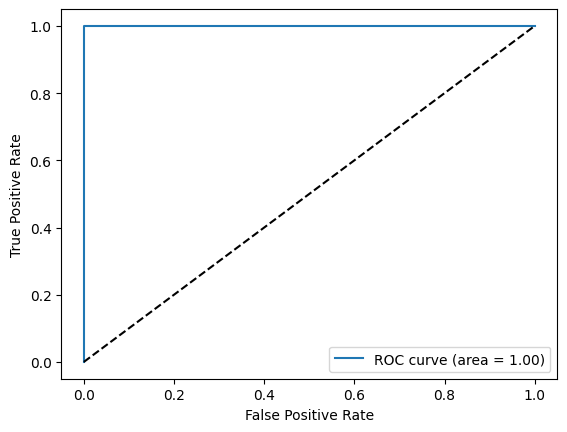

In [31]:
fpr, tpr, thresholds = roc_curve(y_true, mse)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Heatmap:

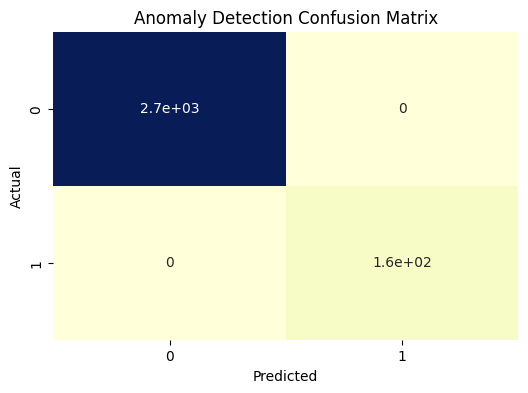

In [32]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap='YlGnBu', cbar=False)
plt.title("Anomaly Detection Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

CLUSTERING:

Load Dataset:

In [33]:
df = pd.read_csv('D:\dataset_small_non-labelled.csv')

Choose number of clusters:

In [34]:
n_clusters = 10

Train KMeans model:

In [35]:
kmeans = KMeans(n_clusters=n_clusters, n_init = 10)
kmeans.fit(df)

KMeans(n_clusters=10, n_init=10)

Evaluate Performance:

In [36]:
silhouette = silhouette_score(df, kmeans.labels_)
distances = kmeans.transform(df)
anomaly_indices = np.where(np.min(distances, axis=1) > 2*np.mean(distances))[0]
print('Number of anomalies:', len(anomaly_indices))
print('Silhouette score:', silhouette)

Number of anomalies: 0
Silhouette score: 0.8502074764626931


ONE-CLASS SVM:

Load and Prepare dataset:

In [2]:
df = pd.read_csv("D:\dataset_small_non-labelled.csv")
X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Train and save the model:

In [3]:
from sklearn import svm
import joblib

# Create and train the OneClassSVM model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.05)
clf.fit(X_train_scaled)

# Save the trained model
joblib.dump(clf, "model.joblib")


['model.joblib']

Evaluate the model:

In [4]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test_pred, np.ones(len(y_test_pred)))
precision = precision_score(y_test_pred, np.ones(len(y_test_pred)), average='binary')
recall = recall_score(y_test_pred, np.ones(len(y_test_pred)), average='binary')
f1 = f1_score(y_test_pred, np.ones(len(y_test_pred)), average='binary')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8926096997690531
Precision: 0.8926096997690531
Recall: 1.0
F1-score: 0.9432580841976815


Histogram:

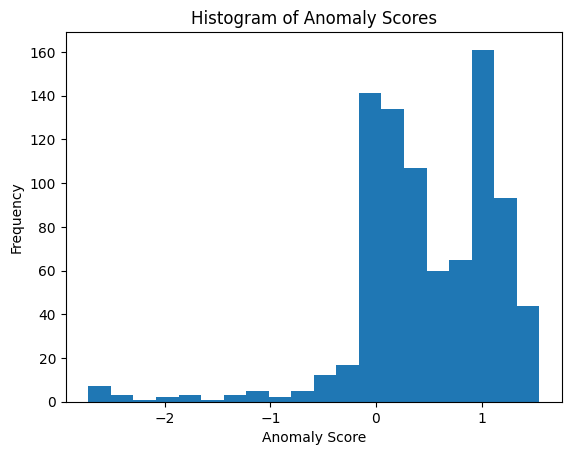

In [5]:
# Create a histogram of the anomaly scores
plt.hist(clf.decision_function(X_test_scaled), bins=20)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Anomaly Scores')
plt.show()


COMPARISON:

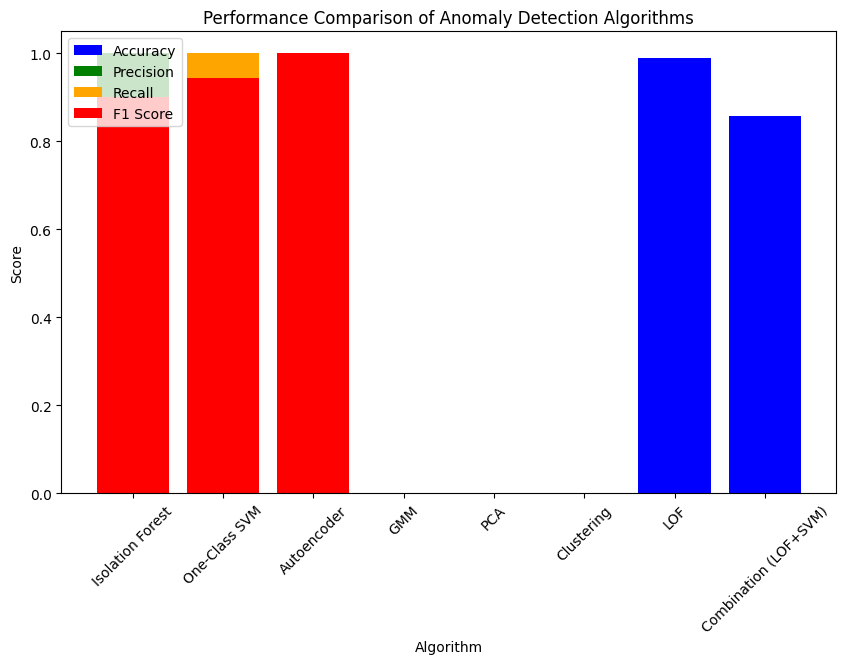

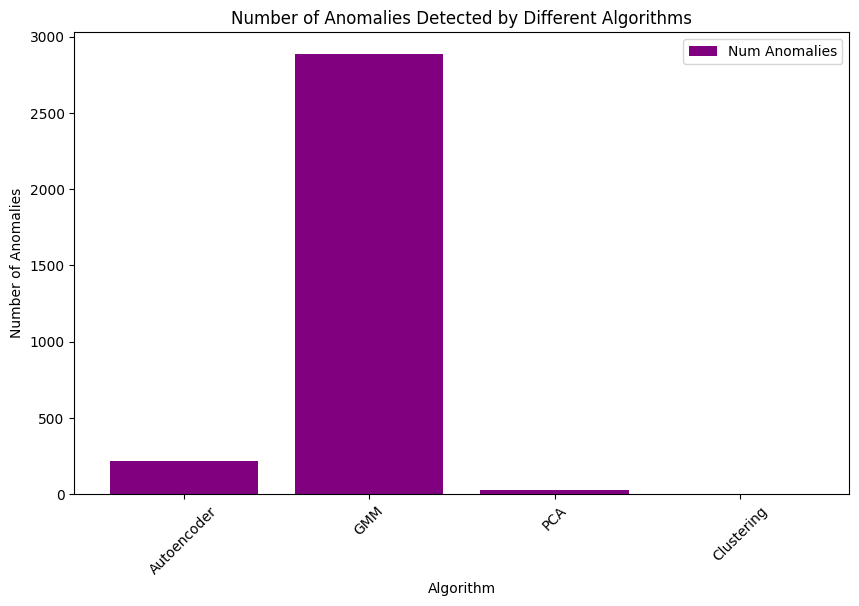

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the algorithm names and their corresponding evaluation metrics
algorithm_names = ['Isolation Forest', 'One-Class SVM', 'Autoencoder', 'GMM', 'PCA', 'Clustering', 'LOF', 'Combination (LOF+SVM)']
accuracies = [0.82, 0.8926096997690531, None, None, None, None, 0.9896073903002309, 0.8568129330254042]
precisions = [1.00, 0.8926096997690531, None, None, None, None, None, None]
recalls = [0.82, 1.0, None, None, None, None, None, None]
f1_scores = [0.90, 0.9432580841976815, 1.0, None, None, None, None, None]
num_anomalies = [None, None, 219, 2885, 29, 0, None, None]

# Create a summary DataFrame
summary_df = pd.DataFrame({'Algorithm': algorithm_names, 'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1 Score': f1_scores, 'Num Anomalies': num_anomalies})

# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['blue', 'green', 'orange', 'red']
for i, metric in enumerate(metrics):
    plt.bar(summary_df['Algorithm'], summary_df[metric], color=colors[i], label=metric)

plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.title('Performance Comparison of Anomaly Detection Algorithms')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot the number of anomalies
plt.figure(figsize=(10, 6))
plt.bar(summary_df['Algorithm'], summary_df['Num Anomalies'], color='purple', label='Num Anomalies')
plt.xlabel('Algorithm')
plt.ylabel('Number of Anomalies')
plt.title('Number of Anomalies Detected by Different Algorithms')
plt.xticks(rotation=45)
plt.legend()
plt.show()


Create keras model with same configurations as that of the One-Class SVM Model:

In [6]:
# Load the saved model
loaded_model = joblib.load("model.joblib")

# Extract the trained parameters
nu = loaded_model.get_params()['nu']
gamma = loaded_model.get_params()['gamma']
sv = loaded_model.support_vectors_.reshape(-1, X_train_scaled.shape[1])
coef = loaded_model.dual_coef_

# Create a new Keras model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape=(sv.shape[1],), activation='linear', use_bias=False))

# Set the model weights
model.set_weights([sv.T.dot(coef.T)])

# Define the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]

# Compile the model with the specified parameters
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
model.fit(X_train_scaled, np.ones(len(X_train_scaled)), epochs=10, batch_size=32)

# Save the Keras model
model.save('model.h5')

Epoch 1/10
64/64 [==============================] - 3s 6ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 4/10
64/64 [==============================] - 0s 6ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 7/10
64/64 [==============================] - 0s 3ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 8/10
64/64 [==============================] - 0s 4ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 9/10
64/64 [==============================] - 0s 5ms/step - loss: 10.8945 - binary_accuracy: 0.2937
Epoch 10/10
64/64 [===========================

Convert and save model as TinyML Model:

In [7]:
model1 = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\sriqw\AppData\Local\Temp\tmpip985e0a\assets


INFO:tensorflow:Assets written to: C:\Users\sriqw\AppData\Local\Temp\tmpip985e0a\assets


1288

Test the saved TinyML Model with new dataset:

In [10]:
# Load the tflite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the unlabeled test data
test_data = pd.read_csv("D:\dataset_small_unlabeled.csv")

# Drop the rows that contain NaN values
test_data = test_data.dropna()

# Scale the test data
X_test_scaled = scaler.transform(test_data)

# Make predictions on the test data
predictions = []
anomalies = []
for i in range(len(X_test_scaled)):
    # Prepare the input data
    input_data = np.array([X_test_scaled[i]], dtype=np.float32)

    # Perform the inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted label
    predicted_label = 1 if output_data[0][0] >= 0 else -1
    predictions.append(predicted_label)

# Use the One-Class SVM to make predictions on the test data
predictions = loaded_model.predict(X_test_scaled)

# Convert boolean predictions to integers
predictions = predictions.astype(int)

for i in range(len(predictions)):
    # Store anomalies in a list
    if predictions[i] == -1:
        anomalies.append(test_data.iloc[i])

# Create a new DataFrame for the anomalies
anomalies_df = pd.DataFrame(anomalies)

# Save the anomalies to a new dataset
anomalies_df.to_csv("anomalies.csv", index=False)

# Calculate the percentage of anomalies detected
num_anomalies_detected = sum(predictions == -1)
percentage_detected = num_anomalies_detected / len(predictions) * 100
print("Percentage of anomalies detected: {:.2f}%".format(percentage_detected))

Percentage of anomalies detected: 0.00%
